In [2]:
%matplotlib inline

AEP 702.4351577190602


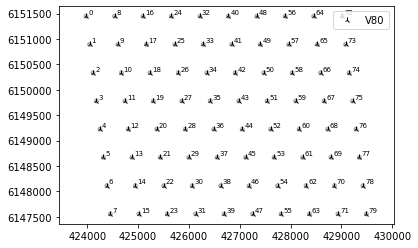

In [3]:
from py_wake.examples.data.hornsrev1 import wt_x, wt_y, HornsrevV80,\
    Hornsrev1Site
from py_wake.wake_models.noj import NOJ
from py_wake.aep_calculator import AEPCalculator


import matplotlib.pyplot as plt
wt = HornsrevV80()
site = Hornsrev1Site()
wt.plot(wt_x, wt_y)
aep_calculator = AEPCalculator(NOJ(site, wt))
print('AEP', aep_calculator.calculate_AEP(wt_x, wt_y).sum())
plt.show()

In [4]:
from py_wake.wake_model import WakeModel, SquaredSum
from py_wake.wake_models.noj import AreaOverlappingFactor
from py_wake.wake_models.gcl import GCL
import numpy as np
import time
from numpy import newaxis as na

/Users/pe/anaconda3/envs/topfarm_clean/lib/python3.7/site-packages/jax/lib/xla_bridge.py:120: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [5]:
from py_wake.wake_models.gcl import *

In [6]:
#import numpy as np
#from numba import jit
import jax.numpy as np
from jax import jit, vmap


from numba import guvectorize

#@jit(['float64[:,:,:,:](float64[:,:,:,:], float64)', 
#      'float64[:,:,:](float64[:,:,:], float64)',
#      'float64[:,:](float64[:,:], float64)',
#      'float64[:](float64[:], float64)', 
#      'float64(float64, float64)'], nopython=True)
#@jit
def my_power(term, factor):
    return np.exp(factor * np.log(term))

#@jit#('float64[:,:,:,:](float64[:,:,:,:], float64[:,:,:,:], float64[:,:,:,:], float64[:])', nopython=True)
def get_r96(D, CT, TI, pars=PARS):
    """Computes the wake radius at 9.6D downstream location of a turbine

    .. math::
        R_{9.6D} = a_1 \\exp (a_2 C_T^2 + a_3 C_T + a_4)  (b_1  TI + b_2)  D

    Inputs
    ----------
    D: float
        Wind turbine diameter
    CT: float
        Outputs WindTurbine object's thrust coefficient
    TI: float
        Ambient turbulence intensity
    pars: list
        GCL Model parameters [a1, a2, a3, a4, b1, b2]

    Returns
    -------
    R96: float
        Wake radius at 9.6D downstream location
    """
    a1, a2, a3, a4, b1, b2 = pars
    R96 = a1 * (np.exp(a2 * CT * CT + a3 * CT + a4)) * (b1 * TI + b2) * D

    return R96

#@jit('float64[:,:,:,:](float64[:,:,:,:], float64[:,:,:,:], float64[:,:,:,:], float64[:])', nopython=True)
def get_Rw(x, R, TI, CT, pars=PARS):
    """Computes the wake radius at a location.
    [1]-eq.3

    .. math::
        R_w = \\left(\\frac{105  c_1^2 }{2 \\pi}\\right)^{0.2} (C_T A (x + x_0))^{1/3}

    with A, the area, and x_0 and c_1 defined as

    .. math::
        x_0 = \\frac{9.6 D}{\\left(\\frac{2 R_96}{k D} \\right)^3 - 1}

        c_1 = \\left(\\frac{k D}{2}\\right)^{5/2}
              \\left(\\frac{105}{2 \\pi} \\right)^{-1/2}
              (C_T A x_0)^{-5/6}

    with k and m defined as

    .. math::
        k = \\sqrt{\\frac{m + 1}{2}}

        m = \\frac{1}{\\sqrt{1 - C_T}}

    Inputs
    ----------
    x: float or ndarray
        Distance between turbines and wake location in the wind direction
    R: float
        Wind turbine radius
    TI: float
        Ambient turbulence intensity
    CT: float
        Outputs WindTurbine object's thrust coefficient

    Returns
    -------
    Rw: float or ndarray
        Wake radius at a location
    """
    D = 2.0 * R
    Area = np.pi * D * D / 4.0

    m = 1.0 / (np.sqrt(1.0 - CT))
    k = np.sqrt((m + 1.0) / 2.0)

    R96 = get_r96(D, CT, TI, pars)

    x0 = (9.6 * D) / (my_power(2.0 * R96 / (k * D), 3.0) - 1.0)
    term1 = my_power(k * D / 2.0, 2.5)
    term2 = my_power(105.0/(2.0*np.pi), -0.5)
    term3 = my_power(CT * Area * x0, -5.0 / 6.0)
    c1 = term1 * term2 * term3

    Rw = my_power(105.0 * c1 * c1 / (2.0 * np.pi), 0.2) * my_power(CT * Area * (x + x0), 1.0 / 3.0)

    #if type(x) == float and x+x0 <= 0.: 
    #    Rw = 0
    #elif type(x) == np.ndarray: 
    Rw = np.where(x + x0 <= 0., 0., Rw)
    return Rw, x0, c1

def get_dU(x,r,R,CT,TI):
    """Computes the wake velocity deficit at a location

    Inputs
    ----------
    x: float
        Distance between turbines and wake location in the wind direction
    r: float
        Radial distance between the turbine and the location
    R: float
        Wake producing turbine's radius [m]
    CT: float
        Outputs WindTurbine object's thrust coefficient
    TI: float
        Ambient turbulence intensity [-]
    order: int, optional

    Returns
    -------
    dU: float
        Wake velocity deficit at a location
    """
    #_ones = np.ones(np.shape(x))

    order=1
    pars=PARS
    D = 2. * R
    Area = np.pi * D * D / 4.
    Rw, x0, c1 = get_Rw(x, R, TI, CT, pars)
    c1s = c1 * c1

    term10 = (1./9.) #*_ones
    xx0 = x+x0
    term20 = my_power(CT * Area / (xx0 * xx0), 1./3.)
    term310 = my_power(r, 1.5)
    term320 = 1.0 / np.sqrt(3. * c1s * CT * Area * (x+x0))
    term30 = term310 * term320
    term41 = my_power(35./(2. * np.pi), 3./10.)
    term42 = my_power(3. * c1s, -0.2)
    term40 = term41 * term42
    t4 = term30 - term40
    dU1 = -term10 * term20 * t4 * t4

    dU = dU1

    # if order == 2:

    #     z_term1 = r**1.5
    #     z_term2 = (CT*Area*(x+x0))**(-0.5)
    #     z_term3 = ((35./(2.*np.pi))**(-3./10.))*((3.*c1*c1)**(-3./10.))
    #     z = z_term1*z_term2*z_term3

    #     d_term = (4./81.)*(((35./(2.*np.pi))**(6./5.))*((3.*c1*c1)**(-12./15.)))

    #     d_4_const = (1./40.)
    #     d_3_const = (-4.+48./40.)*1./19.
    #     d_2_const = (6.+27.*d_3_const)*1./4.
    #     d_1_const = (4.-12.*d_2_const)*1./5.
    #     d_0_const = (-1.-3.*d_2_const)*1./8.

    #     d_0 = d_term*d_0_const
    #     d_1 = d_term*d_1_const
    #     d_2 = d_term*d_2_const
    #     d_3 = d_term*d_3_const
    #     d_4 = d_term*d_4_const

    #     dU2_const = ((CT*Area*((x+x0)**(-2.)))**(2./3.))
    #     dU2_term0 = d_0*(z**0.)
    #     dU2_term1 = d_1*(z**1.)
    #     dU2_term2 = d_2*(z**2.)
    #     dU2_term3 = d_3*(z**3.)
    #     dU2_term4 = d_4*(z**4.)

    #     dU2 = dU2_const*(dU2_term0+dU2_term1+dU2_term2+dU2_term3+dU2_term4)

    #     dU=dU1 + dU2

    #if type(r)==np.ndarray: 
    dU = np.where(np.logical_or(Rw<r, x<=0.), 0., dU)
    #dU[Rw<r]=0. # Outside the wake
    #dU[x<=0.]=0. # upstream the wake gen. WT
    # elif type(r)==float:
    #     if x<=0.: 
    #         dU = 0.
    #     if Rw<r: 
    #         dU = 0.
    #     if CT==0: 
    #         dU = 0.0*dU

    return dU


def get_dU_simple(x,r,R,CT,TI, ouput):
    """Computes the wake velocity deficit at a location

    Inputs
    ----------
    x: float
        Distance between turbines and wake location in the wind direction
    r: float
        Radial distance between the turbine and the location
    R: float
        Wake producing turbine's radius [m]
    CT: float
        Outputs WindTurbine object's thrust coefficient
    TI: float
        Ambient turbulence intensity [-]
    order: int, optional

    Returns
    -------
    dU: float
        Wake velocity deficit at a location
    """
    #_ones = np.ones(np.shape(x))

    order=1
    pars=PARS
    
    D = 2. * R
    Area = np.pi * D * D / 4.

    m = 1.0 / (np.sqrt(1.0 - CT))
    k = np.sqrt((m + 1.0) / 2.0)

    a1, a2, a3, a4, b1, b2 = pars
    R96 = a1 * (np.exp(a2 * CT * CT + a3 * CT + a4)) * (b1 * TI + b2) * D

    x0 = (9.6 * D) / (np.power(2.0 * R96 / (k * D), 3.0) - 1.0)
    term1 = np.power(k * D / 2.0, 2.5)
    term2 = np.power(105.0/(2.0*np.pi), -0.5)
    term3 = np.power(CT * Area * x0, -5.0 / 6.0)
    c1 = term1 * term2 * term3

    Rw = np.power(105.0 * c1 * c1 / (2.0 * np.pi), 0.2) * np.power(CT * Area * (x + x0), 1.0 / 3.0)
    Rw = np.where(x + x0 <= 0., 0., Rw)
    
    c1s = c1 * c1

    term10 = (1./9.) #*_ones
    xx0 = x+x0
    term20 = np.power(CT * Area / (xx0 * xx0), 1./3.)
    term310 = np.power(r, 1.5)
    term320 = 1.0 / np.sqrt(3. * c1s * CT * Area * (x+x0))
    term30 = term310 * term320
    term41 = np.power(35./(2. * np.pi), 3./10.)
    term42 = np.power(3. * c1s, -0.2)
    term40 = term41 * term42
    t4 = term30 - term40
    dU1 = -term10 * term20 * t4 * t4

    dU = dU1
    dU = np.where(np.logical_or(Rw<r, x<=0.), 0., dU)

    output = dU

    
    
get_dtu_simple_jit = jit(get_dU_simple)
get_dU_vmap = jit(vmap(get_dU))
get_dU_jit = jit(get_dU)
get_dU_numba = guvectorize('f8[:,:,:,:], f8[:,:,:,:], f8[:,:,:,:], f8[:,:,:,:], f8[:,:,:,:], f8[:,:,:,:]', 
                           '(j,l,k,r), (j,l,k,r), (j,l,k,r), (j,l,k,r), (j,l,k,r) -> (j,l,k,r)')(get_dU_simple)

@jit
def get_jlkr(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk):
    R_dst_jl = D_dst_jl / 2.
    R_src_l =  D_src_l / 2.

    # Define the dimensions of the arrays
    J, L = dw_jl.shape
    R = node_R.shape[0]
    K = ct_lk.shape[1]

    # Broadcasting the arrays
    WS_jlk = np.broadcast_to(WS_lk[na,:,:], (J,L,K))
    dw_jlkr = np.broadcast_to(dw_jl[:,:,na,na], (J,L,K,R))
    hcw_jlkr = np.broadcast_to(hcw_jl[:,:,na,na], (J,L,K,R))
    dh_jlkr = np.broadcast_to(dh_jl[:,:,na,na], (J,L,K,R))
    node_R_jlkr = np.broadcast_to(node_R[na,na,na,:], (J,L,K,R))
    node_th_jlkr = np.broadcast_to(node_th[na,na,na,:], (J,L,K,R))
    weight_jlkr = np.broadcast_to(weight[na,na,na,:], (J,L,K,R))
    R_dst_jlkr = np.broadcast_to(R_dst_jl[:,:,na,na], (J,L,K,R))
    R_src_jlkr = np.broadcast_to(R_src_l[na,:,na,na], (J,L,K,R))
    ct_jlkr = np.broadcast_to(ct_lk[na,:,:,na], (J,L,K,R))
    TI_jlkr = np.broadcast_to(TI_lk[na,:,:,na], (J,L,K,R))

    # Creating the polar parametrization
    ye_jlkr = hcw_jlkr + R_dst_jlkr * node_R_jlkr * np.cos(node_th_jlkr)
    ze_jlkr = dh_jlkr + R_dst_jlkr * node_R_jlkr * np.sin(node_th_jlkr)
    re_jlkr = np.sqrt( ye_jlkr**2. + ze_jlkr**2. )
    return dw_jlkr, re_jlkr, R_src_jlkr, ct_jlkr, TI_jlkr, weight_jlkr, WS_jlk

@jit
def get_jlk(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk):
    R_dst_jl = D_dst_jl / 2.
    R_src_l =  D_src_l / 2.

    # Define the dimensions of the arrays
    J, L = dw_jl.shape
    K = ct_lk.shape[1]

    # Broadcasting the arrays
    WS_jlk = np.broadcast_to(WS_lk[na,:,:], (J,L,K))
    dw_jlk = np.broadcast_to(dw_jl[:,:,na], (J,L,K))
    hcw_jlk = np.broadcast_to(hcw_jl[:,:,na], (J,L,K))
    dh_jlk = np.broadcast_to(dh_jl[:,:,na], (J,L,K))
    R_dst_jlk = np.broadcast_to(R_dst_jl[:,:,na], (J,L,K))
    R_src_jlk = np.broadcast_to(R_src_l[na,:,na], (J,L,K))
    ct_jlk = np.broadcast_to(ct_lk[na,:,:], (J,L,K))
    TI_jlk = np.broadcast_to(TI_lk[na,:,:], (J,L,K))

    # Creating the polar parametrization
    ye_jlk = hcw_jlk# + R_dst_jlkr * node_R_jlkr * np.cos(node_th_jlkr)
    ze_jlk = dh_jlk# + R_dst_jlkr * node_R_jlkr * np.sin(node_th_jlkr)
    re_jlk = np.sqrt( ye_jlk**2. + ze_jlk**2. )
    return dw_jlk, re_jlk, R_src_jlk, ct_jlk, TI_jlk, WS_jlk

@jit
def gcl_calc_deficit_jax(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, pars):
    dw_jlkr, re_jlkr, R_src_jlkr, ct_jlkr, TI_jlkr, weight_jlkr, WS_jlk = get_jlkr(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk)
    dU_jlkr = get_dU_jit(dw_jlkr, re_jlkr, R_src_jlkr, ct_jlkr, TI_jlkr)
    dUeq_jlk = np.sum(weight_jlkr * dU_jlkr, axis=-1)
    deficit_jlk = WS_jlk * dUeq_jlk
    return deficit_jlk

@jit
def gcl_calc_deficit_jax_vmap(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, pars):
    dw_jlkr, re_jlkr, R_src_jlkr, ct_jlkr, TI_jlkr, weight_jlkr, WS_jlk = get_jlkr(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk)
    dU_jlkr = get_dU_vmap(dw_jlkr, re_jlkr, R_src_jlkr, ct_jlkr, TI_jlkr)
    dUeq_jlk = np.sum(weight_jlkr * dU_jlkr, axis=-1)
    deficit_jlk = WS_jlk * dUeq_jlk
    return deficit_jlk

@jit
def gcl_calc_deficit_jax_simple(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, pars):
    dw_jlkr, re_jlkr, R_src_jlkr, ct_jlkr, TI_jlkr, weight_jlkr, WS_jlk = get_jlkr(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk)
    dU_jlkr = np.ones_like(dw_jlkr)
    get_dtu_simple_jit(dw_jlkr, re_jlkr, R_src_jlkr, ct_jlkr, TI_jlkr, dU_jlkr)
    dUeq_jlk = np.sum(weight_jlkr * dU_jlkr, axis=-1)
    deficit_jlk = WS_jlk * dUeq_jlk
    return deficit_jlk

@jit
def gcl_hh_calc_deficit_jax(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, pars):
    dw_jlk, re_jlk, R_src_jlk, ct_jlk, TI_jlk, WS_jlk = get_jlk(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk)
    dU_jlk = get_dU_jit(dw_jlk, re_jlk, R_src_jlk, ct_jlk, TI_jlk)
    deficit_jlk = WS_jlk * dU_jlk
    return deficit_jlk

def gcl_calc_deficit_dask(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, pars, chunks=None):
    R_dst_jl = D_dst_jl / 2.
    R_src_l =  D_src_l / 2.

    # Define the dimensions of the arrays
    J, L = dw_jl.shape
    R = node_R.shape[0]
    K = ct_lk.shape[1]

    # Broadcasting the arrays
    WS_jlk = da.array.broadcast_to(WS_lk[na,:,:], (J,L,K), chunks)
    dw_jlkr = da.array.broadcast_to(dw_jl[:,:,na,na], (J,L,K,R), chunks)
    hcw_jlkr = da.array.broadcast_to(hcw_jl[:,:,na,na], (J,L,K,R), chunks)
    dh_jlkr = da.array.broadcast_to(dh_jl[:,:,na,na], (J,L,K,R), chunks)
    node_R_jlkr = da.array.broadcast_to(node_R[na,na,na,:], (J,L,K,R), chunks)
    node_th_jlkr = da.array.broadcast_to(node_th[na,na,na,:], (J,L,K,R), chunks)
    weight_jlkr = da.array.broadcast_to(weight[na,na,na,:], (J,L,K,R), chunks)
    R_dst_jlkr = da.array.broadcast_to(R_dst_jl[:,:,na,na], (J,L,K,R), chunks)
    R_src_jlkr = da.array.broadcast_to(R_src_l[na,:,na,na], (J,L,K,R), chunks)
    ct_jlkr = da.array.broadcast_to(ct_lk[na,:,:,na], (J,L,K,R), chunks)
    TI_jlkr = da.array.broadcast_to(TI_lk[na,:,:,na], (J,L,K,R), chunks)

    # Creating the polar parametrization
    ye_jlkr = hcw_jlkr + R_dst_jlkr * node_R_jlkr * np.cos(node_th_jlkr)
    ze_jlkr = dh_jlkr + R_dst_jlkr * node_R_jlkr * np.sin(node_th_jlkr)
    re_jlkr = np.sqrt( ye_jlkr**2. + ze_jlkr**2. )

    dU_jlkr = da.array.zeros_like(TI_jlkr)
    get_dU_numba(dw_jlkr, re_jlkr, R_src_jlkr, ct_jlkr, TI_jlkr, dU_jlkr)
    dUeq_jlk = np.sum(weight_jlkr * dU_jlkr, axis=-1)

    deficit_jlk_dask = WS_jlk * dUeq_jlk
    deficit_jlk = deficit_jlk_dask.compute()
    return deficit_jlk


class GCL(LinearSum, WakeModel):
    args4deficit = ['WS_lk', 'D_src_l', 'D_dst_jl', 'dw_jl', 'hcw_jl', 'dh_jl', 'ct_lk', 'TI_lk']

    def __init__(self, site, windTurbines, pars=PARS, version='jax', **kwargs):
        WakeModel.__init__(self, site, windTurbines, **kwargs)
        self.pars = pars
        self.version = version

    def calc_deficit(self, WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk):
        if self.version == 'numpy':
            return gcl_calc_deficit_jax(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, self.pars)
        if self.version == 'jax':
            return gcl_calc_deficit_jax_vmap(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, self.pars)
        if self.version == 'jax_vmap':
            return gcl_calc_deficit_jax(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, self.pars)
        if self.version == 'jax_simple':
            return gcl_calc_deficit_jax_simple(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, self.pars)
        if self.version == 'hh_jax':
            return gcl_hh_calc_deficit_jax(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, self.pars)
        if self.version == 'dask_numba':
            return gcl_calc_deficit_dask(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, self.pars)

<ipython-input-6-0b82e6908376>:200: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "get_dU_simple" failed type inference due to: Unknown attribute 'sqrt' of type Module(<module 'jax.numpy' from '/Users/pe/anaconda3/envs/topfarm_clean/lib/python3.7/site-packages/jax/numpy/__init__.py'>)

File "<ipython-input-6-0b82e6908376>", line 230:
def get_dU_simple(x,r,R,CT,TI, ouput):
    <source elided>

    m = 1.0 / (np.sqrt(1.0 - CT))
    ^

[1] During: typing of get attribute at <ipython-input-6-0b82e6908376> (230)

File "<ipython-input-6-0b82e6908376>", line 230:
def get_dU_simple(x,r,R,CT,TI, ouput):
    <source elided>

    m = 1.0 / (np.sqrt(1.0 - CT))
    ^

  def get_dU_simple(x,r,R,CT,TI, ouput):
/Users/pe/anaconda3/envs/topfarm_clean/lib/python3.7/site-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "get_dU_simple" was compiled in object mode without forceobj=True.

File "<ipython-input-6-0b82e6908376>", line 200

In [14]:
gcl_aep_calculator = AEPCalculator(GCL(site, wt, version='hh_jax'))

In [15]:
wt_x = np.array(wt_x) +10
wt_y = np.array(wt_y)

n_ws = 20
n_wd = 360

In [19]:
t1 = time.time()
aep = gcl_aep_calculator.calculate_AEP(wt_x, wt_y, 
          ws=np.linspace(4., 25., 20),
          wd=np.linspace(0., 360., 360, endpoint=False))
print(aep.sum())
t2 = time.time()
t2-t1

814.482414536628


1.3218553066253662

In [17]:
%%timeit
aep = gcl_aep_calculator.calculate_AEP(wt_x, wt_y, 
          ws=np.linspace(4., 25., 20),
          wd=np.linspace(0., 360., 360, endpoint=False))



1.24 s ± 87.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
noj_aep_calculator = AEPCalculator(NOJ(site, wt))

In [82]:
n_ws, n_wd = 20, 360

In [83]:
t1 = time.time()
aep = noj_aep_calculator.calculate_AEP(wt_x, wt_y, 
          ws=np.linspace(4., 25., n_ws),
          wd=np.linspace(0., 360., n_wd, endpoint=False))

t2 = time.time()
print(aep.sum())
print(t2-t1)

702.0954949619451
0.8536200523376465


In [84]:
%%timeit
aep = noj_aep_calculator.calculate_AEP(wt_x, wt_y, 
          ws=np.linspace(4., 25., n_ws),
          wd=np.linspace(0., 360., n_wd, endpoint=False))

833 ms ± 1.74 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [63]:
my_power(np.array([1,2,3.]), 2.)

array([1., 4., 9.])

In [36]:
def examine_jaxpr(typed_jaxpr):
  jaxpr = typed_jaxpr.jaxpr
  print("invars:", jaxpr.invars)
  print("outvars:", jaxpr.outvars)
  print("constvars:", jaxpr.constvars)
  print("freevars:", jaxpr.freevars)
  for eqn in jaxpr.eqns:
    print("equation:", eqn.invars, eqn.primitive, eqn.outvars, eqn.params)
  print()
  print("jaxpr:", jaxpr)


In [10]:
%load_ext line_profiler

In [11]:
aep_calculator = AEPCalculator(GCL(site, wt))


In [12]:
aep = aep_calculator.calculate_AEP(wt_x, wt_y, 
          ws=np.linspace(4., 25., 5),
          wd=np.linspace(0., 360., 4, endpoint=False))
aep.sum()

AttributeError: 'ShapedArray' object has no attribute 'block_until_ready'

In [8]:
ws=np.linspace(4., 25., 5),
wd=np.linspace(0., 360., 4, endpoint=False)

In [9]:
from py_wake.wake_models.gcl import *

In [31]:
%%timeit
aep = aep_calculator.calculate_AEP(wt_x, wt_y, 
          ws=np.linspace(4., 25., 10),
          wd=np.linspace(0., 360., 36, endpoint=False))
aep.sum()

4.01 s ± 72.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
import time

In [34]:
t1 = time.time()
aep = aep_calculator.calculate_AEP(wt_x, wt_y, 
          ws=np.linspace(4., 25., 20),
          wd=np.linspace(0., 360., 360, endpoint=False))
aep.sum()
t2 = time.time()
t2-t1

4.0020668506622314

In [33]:
aep.sum()

811.7840009721534

In [35]:
from jax import grad, jit, vmap

In [41]:
class JaxWakeModel(WakeModel):
    """

    Suffixes:

    - d: turbines down wind order
    - i: turbines ordered by id
    - j: downstream points/turbines
    - k: wind speeds
    - l: wind directions
    - m: turbines and wind directions (il.flatten())
    - n: from_turbines, to_turbines and wind directions (iil.flatten())

    Arguments available for calc_deficit (specifiy in args4deficit):

    - WS_lk: Local wind speed without wake effects
    - TI_lk: local turbulence intensity without wake effects
    - WS_eff_lk: Local wind speed with wake effects
    - TI_eff_lk: local turbulence intensity with wake effects
    - D_src_l: Diameter of source turbine
    - D_dst_jl: Diameter of destination turbine
    - dw_jl: Downwind distance from turbine i to point/turbine j
    - hcw_jl: Horizontal cross wind distance from turbine i to point/turbine j
    - cw_jl: Cross wind(horizontal and vertical) distance from turbine i to point/turbine j
    - ct_lk: Thrust coefficient

    """

    def calc_wake(self, x_i, y_i, h_i=None, type_i=None, wd=None, ws=None):
        """Calculate wake effects

        Calculate effective wind speed, turbulence intensity (not
        implemented yet), power and thrust coefficient, and local
        site parameters

        Parameters
        ----------
        x_i : array_like
            X position of wind turbines
        y_i : array_like
            Y position of wind turbines
        h_i : array_like or None, optional
            Hub height of wind turbines\n
            If None, default, the standard hub height is used
        type_i : array_like or None, optional
            Wind turbine types\n
            If None, default, the first type is used (type=0)
        wd : int, float, array_like or None
            Wind directions(s)\n
            If None, default, the wake is calculated for site.default_wd
        ws : int, float, array_like or None
            Wind speed(s)\n
            If None, default, the wake is calculated for site.default_ws


        Returns
        -------
        WS_eff_ilk : array_like
            Effective wind speeds [m/s]
        TI_eff_ilk : array_like
            Turbulence intensities. Should be effective, but not implemented yet
        power_ilk : array_like
            Power productions [w]
        ct_ilk : array_like
            Thrust coefficients
        WD_ilk : array_like
            Wind direction(s)
        WS_ilk : array_like
            Wind speed(s)
        TI_ilk : array_like
            Ambient turbulence intensitie(s)
        P_ilk : array_like
            Probability
        """

        type_i, h_i, D_i = self.windTurbines.get_defaults(len(x_i), type_i, h_i)
        wd, ws = self.site.get_defaults(wd, ws)

        # Find local wind speed, wind direction, turbulence intensity and probability
        WD_ilk, WS_ilk, TI_ilk, P_ilk = self.site.local_wind(x_i=x_i, y_i=y_i, h_i=h_i, wd=wd, ws=ws)

        # Calculate down-wind and cross-wind distances
        dw_iil, hcw_iil, dh_iil, dw_order_indices_dl = self.site.wt2wt_distances(x_i, y_i, h_i, WD_ilk.mean(2))

        I, L = dw_iil.shape[1:]
        i1, i2, _ = np.where((np.abs(dw_iil) + np.abs(hcw_iil) + np.eye(I)[:, :, na]) == 0)
        if len(i1):
            msg = "\n".join(["Turbines %d and %d are at the same position" %
                             (i1[i], i2[i]) for i in range(len(i1))])
            raise ValueError(msg)

        K = WS_ilk.shape[2]
        deficit_nk = np.zeros((I * I * L, K))

        from py_wake.turbulence_model import TurbulenceModel
        calc_ti = isinstance(self, TurbulenceModel)

        if calc_ti:
            add_turb_nk = np.zeros((I * I * L, K))

        indices = np.arange(I * I * L).reshape((I, I, L))
        WS_mk = WS_ilk.astype(np.float).reshape((I * L, K))
        WS_eff_mk = WS_mk.copy()
        TI_mk = TI_ilk.astype(np.float).reshape((I * L, K))
        TI_eff_mk = TI_mk.copy()
        dw_n = dw_iil.flatten()
        hcw_n = hcw_iil.flatten()
        if self.wec != 1:
            hcw_n = hcw_n / self.wec
        dh_n = dh_iil.flatten()
        power_ilk = np.zeros((I, L, K))
        ct_ilk = np.zeros((I, L, K))
        i_wd_l = np.arange(L)

        # Iterate over turbines in down wind order
        for j in range(I):
            i_wt_l = dw_order_indices_dl[:, j]
            m = i_wt_l * L + i_wd_l  # current wt (j'th most upstream wts for all wdirs)

            # generate indexes of up wind(n_uw) and down wind(n_dw) turbines
            n_uw = np.array([indices[uwi, i, l] for uwi, i, l in zip(dw_order_indices_dl[:, :j], i_wt_l, i_wd_l)]).T
            n_dw = np.array([indices[i, dwi, l] for dwi, i, l in zip(dw_order_indices_dl[:, j + 1:], i_wt_l, i_wd_l)]).T

            # Calculate effectiv wind speed at current turbines(all wind directions and wind speeds) and
            # look up power and thrust coefficient
            if j == 0:  # Most upstream turbines (no wake)
                WS_eff_lk = WS_mk[m]
            else:  # 2..n most upstream turbines (wake)
                WS_eff_lk = self.calc_effective_WS(WS_mk[m], deficit_nk[n_uw])
                WS_eff_mk[m] = WS_eff_lk
                if calc_ti:
                    TI_eff_mk[m] = self.calc_effective_TI(TI_mk[m], add_turb_nk[n_uw])

            ct_lk, power_lk = self.windTurbines._ct_power(WS_eff_lk, type_i[i_wt_l])

            power_ilk[i_wt_l, i_wd_l] = power_lk
            ct_ilk[i_wt_l, i_wd_l, :] = ct_lk

            if j < I - 1:
                # Calculate required args4deficit parameters
                arg_funcs = {'WS_lk': lambda: WS_mk[m],
                             'WS_eff_lk': lambda: WS_eff_mk[m],
                             'TI_lk': lambda: TI_mk[m],
                             'TI_eff_lk': lambda: TI_eff_mk[m],
                             'D_src_l': lambda: D_i[i_wt_l],
                             'D_dst_jl': lambda: D_i[dw_order_indices_dl[:, j + 1:]].T,
                             'dw_jl': lambda: dw_n[n_dw],
                             'cw_jl': lambda: np.hypot(hcw_n[n_dw], dh_n[n_dw]),
                             'hcw_jl': lambda: hcw_n[n_dw],
                             'dh_jl': lambda: dh_n[n_dw],
                             'h_l': lambda: h_i[i_wt_l],
                             'ct_lk': lambda: ct_lk}
                args = {k: arg_funcs[k]() for k in self.args4deficit}

                # Calcualte deficit
                deficit_nk[n_dw] = self.calc_deficit(**args)
                if calc_ti:
                    # Calculate required args4deficit parameters and calculate added turbulence
                    args = {k: arg_funcs[k]() for k in self.args4addturb}
                    add_turb_nk[n_dw] = self.calc_added_turbulence(**args)

        WS_eff_ilk = WS_eff_mk.reshape((I, L, K))
        TI_eff_ilk = TI_eff_mk.reshape((I, L, K))

        return WS_eff_ilk, TI_eff_ilk, power_ilk, ct_ilk, WD_ilk, WS_ilk, TI_ilk, P_ilk

In [42]:
from py_wake.wake_models.gcl import *

In [43]:
class JaxGCL(LinearSum, JaxWakeModel):
    args4deficit = ['WS_lk', 'D_src_l', 'D_dst_jl', 'dw_jl', 'hcw_jl', 'dh_jl', 'ct_lk', 'TI_lk']

    def __init__(self, site, windTurbines, pars=PARS, **kwargs):
        WakeModel.__init__(self, site, windTurbines, **kwargs)
        self.pars = pars

    def calc_deficit(self, WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk):
        return gcl_calc_deficit(WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk, self.pars)



In [44]:
aep_calculator = AEPCalculator(JaxGCL(site, wt))

In [45]:
t1 = time.time()
aep = aep_calculator.calculate_AEP(wt_x, wt_y, 
          ws=np.linspace(4., 25., 2),
          wd=np.linspace(0., 360., 12, endpoint=False))
aep.sum()
t2 = time.time()
t2-t1

ValueError: Must use the three-argument form of where().

In [13]:
%lprun -f get_dU aep_calculator.calculate_AEP(wt_x, wt_y, ws=ws, wd=wd)

Timer unit: 1e-06 s

Total time: 0.528956 s
File: /Users/pe/git/TOPFARM/PyWake/py_wake/wake_models/gcl.py
Function: get_dU at line 139

Line #      Hits         Time  Per Hit   % Time  Line Contents
   139                                           def get_dU(x,r,R,CT,TI, order=1, pars=PARS):
   140                                               """Computes the wake velocity deficit at a location
   141                                           
   142                                               Inputs
   143                                               ----------
   144                                               x: float
   145                                                   Distance between turbines and wake location in the wind direction
   146                                               r: float
   147                                                   Radial distance between the turbine and the location
   148                                               R: float
   149   

In [26]:
from IPython.display import Latex

## Algorithm `pyWake.WakeModel.calc_wake`

```python
begin:
   for i:= 1 to 10 step 1 do:
     expt(2, i)
```


In [27]:
class MyNOJ(SquaredSum, MyWakeModel, AreaOverlappingFactor):
    args4deficit = ['WS_lk', 'D_src_l', 'D_dst_jl', 'dw_jl', 'cw_jl', 'ct_lk']

    def __init__(self, site, windTurbines, k=.1, **kwargs):
        WakeModel.__init__(self, site, windTurbines, **kwargs)
        AreaOverlappingFactor.__init__(self, k)

    def calc_deficit(self, WS_lk, D_src_l, D_dst_jl, dw_jl, cw_jl, ct_lk):

        # Calculate the wake loss using NOJ
        # Jensen, Niels Otto. "A note on wind generator interaction." (1983)
        # V_def = v*(1-sqrt(1-Ct))/(1+k*dist_down/R)**2

        R_src_l = D_src_l / 2

        term_denominator_jl = (1 + self.k * dw_jl / R_src_l[na, :])**2

        A_ol_factor_jl = self.overlapping_area_factor(dw_jl, cw_jl, D_src_l, D_dst_jl)
        term_numerator_lk = WS_lk * (1 - np.sqrt(1 - ct_lk))
        with np.warnings.catch_warnings():
            np.warnings.filterwarnings('ignore', r'invalid value encountered in true_divide')
            deficit_jlk = term_numerator_lk[na] * (A_ol_factor_jl / term_denominator_jl)[:, :, na]
        return deficit_jlk


In [32]:
#wt = HornsrevV80()
#site = Hornsrev1Site()
#wt.plot(wt_x, wt_y)
my_aep_calculator = AEPCalculator(GCL(site, wt))
print('AEP', my_aep_calculator.calculate_AEP(wt_x, wt_y)[0].sum())
#plt.show()

/Users/pe/git/TOPFARM/PyWake/py_wake/wake_models/gcl.py:126: RuntimeWarning: divide by zero encountered in power
  term3 = (CT * Area * x0)**(-5.0 / 6.0)
/Users/pe/git/TOPFARM/PyWake/py_wake/wake_models/gcl.py:129: RuntimeWarning: invalid value encountered in multiply
  Rw = ((105.0 * c1**2.0 / (2.0 * np.pi))**0.2) * (CT * Area * (x + x0 * _ones))**(1.0 / 3.0)
/Users/pe/git/TOPFARM/PyWake/py_wake/wake_models/gcl.py:166: RuntimeWarning: invalid value encountered in multiply
  term320=(3.*c1*c1*CT*Area*(x+x0))**(-0.5)
/Users/pe/git/TOPFARM/PyWake/py_wake/wake_models/gcl.py:207: RuntimeWarning: invalid value encountered in less
  if type(r)==np.ndarray: dU[Rw<r]=0. # Outside the wake


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
my_aep_calculator.calculate_AEP(wt_x, wt_y)

In [28]:
#wt = HornsrevV80()
#site = Hornsrev1Site()
#wt.plot(wt_x, wt_y)
my_aep_calculator = AEPCalculator(MyNOJ(site, wt))
print('AEP', my_aep_calculator.calculate_AEP(wt_x, wt_y)[0].sum())
#plt.show()

AEP 9.076617230949482


In [29]:
#%%timeit
my_aep_calculator = AEPCalculator(MyNOJ(site, wt))
out = my_aep_calculator.calculate_AEP(wt_x, wt_y)[0].sum()
print('AEP', out)

AEP 9.076617230949482


In [30]:
#%%timeit
aep_calculator = AEPCalculator(NOJ(site, wt))
out = my_aep_calculator.calculate_AEP(wt_x, wt_y)[0].sum()
print('AEP', out)

AEP 9.076617230949482


In [10]:
import tensorflow as tf

In [11]:
## Convenient function to change from WD in 360deg to radians
radians = lambda x: (270.0-x)*np.pi/180.0

def ROTfunc(layout, wind_direction, O=np):
    radangle = radians(wind_direction)
    ROT = O.array([[O.cos(radangle), O.sin(radangle)],
                        [-O.sin(radangle), O.cos(radangle)]])
    wtp = layout - O.mean(layout, axis=0)
    rot_pos = O.transpose(O.dot(ROT, O.transpose(wtp)))
    Xp = rot_pos[:,0]
    Yp = rot_pos[:,1]
    return Xp, Yp

def ROTfunc_tensor(layout, wind_direction, O=np):
    radangle = radians(wind_direction)
    ROT = O.array([[O.cos(radangle), O.sin(radangle)],
                        [-O.sin(radangle), O.cos(radangle)]])
    wtp = layout - O.mean(layout, axis=0)
    rot_pos = O.transpose(O.tensordot(ROT, O.transpose(wtp), axes=((1), (0))))
    Xp = rot_pos[:,0]
    Yp = rot_pos[:,1]
    return Xp, Yp

tf_radians = lambda x: (270.0-x)*tf.pi/180.0

@tf.function
def ROTfunc_tf(layout, wind_direction):
    radangle = (270.0-wind_direction)*np.pi/180.0
    ROT = tf.stack([[tf.cos(radangle), tf.sin(radangle)],
                    [-tf.sin(radangle), tf.cos(radangle)]])
    wtp = layout - tf.reduce_mean(layout, axis=0)
    ROT = to_f64(ROT)
    rot_pos = tf.transpose(tf.tensordot(ROT, tf.transpose(wtp), axes=((1), (0))))
    Xp = rot_pos[:,0]
    Yp = rot_pos[:,1]
    return Xp, Yp



In [181]:
import numpy as npy
wind_direction = 270.0
angle = (90.0-wind_direction)*npy.pi/180.0
ROT = npy.array([[ npy.cos(angle), npy.sin(angle), 0],
                 [-npy.sin(angle), npy.cos(angle), 0],
                 [0,0,1]])
wtp = npy.array([[0., 0., 90], [0., 1., 90], [0., 2., 90], [0., 3., 90], [0., 4., 90]])
xy_mean = npy.mean(wtp, axis=0)
xy_mean[2] = 0.0
wtp -= xy_mean
out = npy.tensordot(ROT, wtp.T, axes=((1), (0))).T
print(wtp)
print(out)

[[ 0. -2. 90.]
 [ 0. -1. 90.]
 [ 0.  0. 90.]
 [ 0.  1. 90.]
 [ 0.  2. 90.]]
[[ 2.4492936e-16  2.0000000e+00  9.0000000e+01]
 [ 1.2246468e-16  1.0000000e+00  9.0000000e+01]
 [ 0.0000000e+00  0.0000000e+00  9.0000000e+01]
 [-1.2246468e-16 -1.0000000e+00  9.0000000e+01]
 [-2.4492936e-16 -2.0000000e+00  9.0000000e+01]]


In [182]:
wtp

array([[ 0., -2., 90.],
       [ 0., -1., 90.],
       [ 0.,  0., 90.],
       [ 0.,  1., 90.],
       [ 0.,  2., 90.]])

In [183]:
npy.mean(wtp, axis=0)

array([ 0.,  0., 90.])

In [184]:
import matplotlib.pylab as plt

In [185]:
wtp.shape

(5, 3)

In [186]:
out.shape

(5, 3)

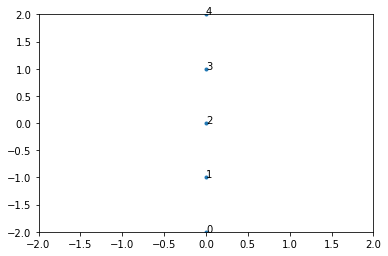

In [188]:
plt.plot(wtp[:,0], wtp[:,1], '.')
plt.ylim([-2, 2])
plt.xlim([-2, 2])
[plt.text(wtp[i,0], wtp[i,1], f'{i}') for i in range(wtp.shape[0])];

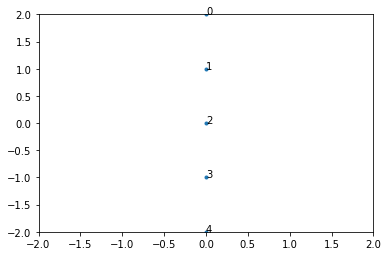

In [189]:
plt.plot(out[:,0], out[:,1], '.')
plt.ylim([-2, 2])
plt.xlim([-2, 2])
[plt.text(out[i,0], out[i,1], f'{i}') for i in range(out.shape[0])];

In [166]:
layout = site.initial_position
n_wt = layout.shape[0]
hub_heights = wt.hub_height() * np.ones([n_wt])
rotor_diameters = wt.diameter()  * np.ones([n_wt])

In [13]:
np.testing.assert_array_almost_equal(
    ROTfunc(layout, wind_direction=0., O=np), 
    ROTfunc_tensor(layout, wind_direction=0., O=np))

In [14]:
def T2Tfunc(Xp, Yp, Zp, O=np):
    Xp_size = O.size(Xp)
    Yp_size = O.size(Xp)
    Zp_size = O.size(Xp)
    
    #DX1 = O.tile(Xp, (Xp_size, 1)).reshape((Xp_size, Xp_size))
    #DY1 = O.tile(Yp, (Yp_size, 1)).reshape((Yp_size, Yp_size))
    #DZ1 = O.tile(Zp, (Zp_size, 1)).reshape((Zp_size, Zp_size))
    DX1 = O.broadcast_to(Xp, (Xp_size, Xp_size))#.reshape((Xp_size, Xp_size))
    DY1 = O.broadcast_to(Yp, (Yp_size, Yp_size))#.reshape((Yp_size, Yp_size))
    DZ1 = O.broadcast_to(Zp, (Zp_size, Zp_size))#.reshape((Zp_size, Zp_size))
    
    DX = DX1 - O.transpose(DX1)
    DY = DY1 - O.transpose(DY1)
    DZ = DZ1 - O.transpose(DZ1)
    return DX, DY, DZ

def my_modif_old(Xo, O=np):
    Xo_size = O.size(Xo)
    DXo = O.tile(O.expand_dims(Xo, axis=0), (Xo_size, 1))
    DXo = O.reshape(DXo, (Xo_size, Xo_size))
    DXo = DXo - O.transpose(DXo)
    return DXo

def my_modif(Xo, O=np):
    DXo =  Xo[O.newaxis, :] - Xo[:, O.newaxis]
    return DXo

def T2Tfunc2(Xp, Yp, Zp, O=np):
    DX = my_modif(Xp, O)
    DY = my_modif(Yp, O)
    DZ = my_modif(hub_heights, O)
    return DX, DY, DZ

def rotate_frame(layout, wind_direction, hub_heights, Rotf=ROTfunc_tf):
    # Rotate the position of the turbines so that the flow is aligned with x direction.
    Xp, Yp = Rotf(layout, wind_direction)
    # Calculate the distance between turbine hub_heights in the frame of reference of each turbine
    DX, DY, DZ = T2Tfunc2(Xp, Yp, hub_heights, O=O)
    return DX, DY, DZ

def rotate_frame2(layout, wind_direction, hub_heights):
    # Rotate the position of the turbines so that the flow is aligned with x direction.
    radangle = (270.0-wind_direction)*np.pi/180.0
    ROT = tf.stack([[tf.cos(radangle), tf.sin(radangle)],
                    [-tf.sin(radangle), tf.cos(radangle)]])
    wtp = layout - tf.reduce_mean(layout, axis=0)
    ROT = to_f64(ROT)
    rot_pos = tf.transpose(tf.tensordot(ROT, tf.transpose(wtp), axes=((1), (0))))
    Drot_pos = rot_pos[O.newaxis, :, :] - rot_pos[:, O.newaxis, :]
    # Calculate the distance between turbine hub_heights in the frame of reference of each turbine
    DZ = hub_heights[O.newaxis, :] - hub_heights[:, O.newaxis]
    return Drot_pos[:,:,0], Drot_pos[:,:,1], DZ

In [15]:
layout = to_f64(layout)
hub_heights = to_f64(hub_heights)
rotor_diameters = to_f64(rotor_diameters)
#wind_direction = to_f64(wind_direction)
a = rotate_frame(layout, 0., hub_heights, Rotf=ROTfunc_tensor)
b = rotate_frame2(layout, 0., hub_heights)
np.testing.assert_array_almost_equal(a, b)

NameError: name 'to_f64' is not defined

In [410]:
def flatten(Xo, O):
    return O.reshape(Xo, [-1])

def build_frame(layout, hub_heights, rotor_diameters, wind_direction, O=np, Rotf=ROTfunc):
    """Method to create the frame to make a wind farm flow computation
    """
    nWT = rotor_diameters.shape[0]
    # Rotate the position of the turbines so that the flow is aligned with x direction.
    Xp, Yp = Rotf(layout, wind_direction)
    # Calculate the distance between turbine hub_heights in the frame of reference of each turbine
    DX, DY, DZ = T2Tfunc2(Xp, Yp, hub_heights, O=O)
    #np.testing.assert_array_almost_equal(my_modif(Xp, O), my_modif_old(Xp, O))
    # Extend the wind turbine rotor radius matrice to correspond to the frame
    R_WT = rotor_diameters / 2.0
    #R_WT = to_f64(R_WT)
    #R = O.tile(R_WT[:, O.newaxis], (1, nWT))
    R = O.broadcast_to(R_WT[:, O.newaxis], (nWT, nWT))
    #R = O.reshape(R, [nWT, nWT])
    # The upstream rotor is the transpose of the turbine rotor
    uR = O.transpose(R)
    #DX = flatten(DX, O)
    #DY = flatten(DY, O)
    #DZ = flatten(DZ, O)
    #uR = flatten(uR, O)
    #R = flatten(R, O)
    return DX, DY, DZ, uR, R

def to_f64(Xo):
    return tf.cast(Xo, 'float64')

@tf.function
def build_frame_tf(layout, hub_heights, rotor_diameters, wind_direction):
    # Make sure that the layout is in float
    layout = to_f64(layout)
    hub_heights = to_f64(hub_heights)
    rotor_diameters = to_f64(rotor_diameters)
    wind_direction = to_f64(wind_direction)
    return build_frame(layout, hub_heights, rotor_diameters, wind_direction, O=tf, Rotf=ROTfunc_tf)

In [411]:
R_WT = rotor_diameters / 2.0
#R_WT = to_f64(R_WT)
R = O.tile(R_WT[:, tf.newaxis], (1, nWT))
#R = O.reshape(R, [nWT, nWT])

In [412]:
R

<tf.Tensor: id=10902, shape=(80, 80), dtype=float64, numpy=
array([[40., 40., 40., ..., 40., 40., 40.],
       [40., 40., 40., ..., 40., 40., 40.],
       [40., 40., 40., ..., 40., 40., 40.],
       ...,
       [40., 40., 40., ..., 40., 40., 40.],
       [40., 40., 40., ..., 40., 40., 40.],
       [40., 40., 40., ..., 40., 40., 40.]])>

In [413]:
tf.reshape(tf.tile(rotor_diameters[:, tf.newaxis], (n_wt, 1)), [-1])

<tf.Tensor: id=10907, shape=(6400,), dtype=float64, numpy=array([80., 80., 80., ..., 80., 80., 80.])>

In [414]:
#```python
O=tf
nWT = rotor_diameters.shape[0]
#wind_direction = to_f64(wind_direction)
tf_layout = to_f64(layout)
tf_hub_heights = to_f64(hub_heights)
tf_rotor_diameters = to_f64(rotor_diameters)
tf_wind_direction = to_f64(0.)
# Rotate the position of the turbines so that the flow is aligned with x direction.
Xp, Yp = ROTfunc_tf(tf_layout, tf_wind_direction)
# Calculate the distance between turbine hub_heights in the frame of reference of each turbine
#DX, DY, DZ = T2Tfunc(Xp, Yp, hub_heights, O=O)


DX, DY, DZ = T2Tfunc2(Xp, Yp, tf_hub_heights, O=O)

# Extend the wind turbine rotor radius matrice to correspond to the frame
R_WT = tf_rotor_diameters / 2.0
R = O.tile(R_WT[:, tf.newaxis], (nWT, 1))
R = O.reshape(R, [nWT, nWT])
# The upstream rotor is the transpose of the turbine rotor
uR = O.transpose(R)



DX_, DY_, DZ_ = T2Tfunc(Xp, Yp, hub_heights, O=np)

np.testing.assert_array_almost_equal(DX, DX_)
np.testing.assert_array_almost_equal(DY, DY_)
np.testing.assert_array_almost_equal(DZ, DZ_)

In [415]:
a = build_frame(layout, hub_heights, rotor_diameters, wind_direction=0.)

In [416]:
b = build_frame_tf(layout, hub_heights, rotor_diameters, wind_direction=0.)

In [391]:
for a_, b_ in zip(a, b): 
    np.testing.assert_array_almost_equal(a_, b_, decimal=6)

In [392]:
%%timeit
s_np = np.concatenate([np.stack(build_frame(layout, hub_heights, rotor_diameters, wind_direction=wd), axis=1) 
                       for wd in np.linspace(0., 360., 360, endpoint=False)], axis=0)

110 ms ± 5.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [393]:
@tf.function
def build_total_frame_tf(layout, hub_heights, rotor_diameters, wds):
    return tf.concat(tf.map_fn(
        lambda wd: tf.stack(build_frame_tf(layout, hub_heights, rotor_diameters, wind_direction=wd), axis=1), wds), axis=1)

def build_total_frame_np(layout, hub_heights, rotor_diameters, wds):
    return np.stack([np.stack(build_frame(layout, hub_heights, rotor_diameters, wind_direction=wd), axis=1) 
                           for wd in np.linspace(0., 360., 360, endpoint=False)], axis=0)

@tf.function
def get_total_frame_tf(layout, hub_heights, rotor_diameters, wds):
    s_tf  = build_total_frame_tf(layout, hub_heights, rotor_diameters, wds) # shape: (K, I, 5, I)
    s_tf = tf.transpose(s_tf, perm=[1, 3, 0, 2]) # shape: (I, I, K, 5)
    # Let's unpack it
    dw_iil = s_tf[:,:,:,0]
    hcw_iil = s_tf[:,:,:,1]
    dh_iil = s_tf[:,:,:,2]
    D_src_iil = s_tf[:,:,:,3]
    D_dst_iil = s_tf[:,:,:,4]
    return dw_iil, hcw_iil, dh_iil, D_src_iil, D_dst_iil

In [394]:
wds_np = np.linspace(0., 360., 360, endpoint=False)
wds_tf = tf.constant(wds_np)

In [395]:
%%timeit
s_tf = build_total_frame_tf(layout, hub_heights, rotor_diameters, wds_tf)

156 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [396]:
%%timeit
s_tf = build_total_frame_tf(layout, hub_heights, rotor_diameters, wds_np)

155 ms ± 5.02 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


a bit faster when converting the vector to tf.constant in the first place

In [294]:
s_np = build_total_frame_np(layout, hub_heights, rotor_diameters, wds_np)

In [295]:
s_tf = build_total_frame_tf(layout, hub_heights, rotor_diameters, wds_tf)

In [296]:
s_np.shape

(360, 80, 5, 80)

In [297]:
s_tf.shape

TensorShape([360, 80, 5, 80])

In [298]:
np.testing.assert_array_almost_equal(s_np, s_tf, decimal=6)

Same output!


Suffixes:

- d: turbines down wind order
- i: turbines ordered by id
- j: downstream points/turbines
- k: wind speeds
- l: wind directions
- m: turbines and wind directions (il.flatten())
- n: from_turbines, to_turbines and wind directions (iil.flatten())

Arguments available for calc_deficit (specifiy in args4deficit):

- WS_lk: Local wind speed without wake effects
- TI_lk: local turbulence intensity without wake effects
- WS_eff_lk: Local wind speed with wake effects
- TI_eff_lk: local turbulence intensity with wake effects
- D_src_l: Diameter of source turbine
- D_dst_jl: Diameter of destination turbine
- dw_jl: Downwind distance from turbine i to point/turbine j
- hcw_jl: Horizontal cross wind distance from turbine i to point/turbine j
- cw_jl: Cross wind(horizontal and vertical) distance from turbine i to point/turbine j
- ct_lk: Thrust coefficient
- h_l: hub height per wind direction

In [299]:
a = np.array([1, 2])
a[:, np.newaxis] + a[np.newaxis, :]

array([[2, 3],
       [3, 4]])

In [300]:
a = tf.constant([1, 2])
a[:, tf.newaxis] + a[tf.newaxis, :]

<tf.Tensor: id=5828, shape=(2, 2), dtype=int32, numpy=
array([[2, 3],
       [3, 4]], dtype=int32)>

#### TODO:

In [301]:
WS_ilk = 8.0 * np.ones([n_wt, 360, 20])

In [343]:
@tf.function
def tf_fuga_lut(dw_iil, hcw_iil, dh_iil, h_iil, D_src_iil):
    return tf.ones_like(dw_iil)

@tf.function
def tf_ct_curve(WS_eff_ilk):
    return 0.8 * tf.ones_like(WS_eff_ilk)

@tf.function
def tf_fuga_calc_deficit(dw_iil, hcw_iil, dh_iil, h_iil, D_src_iil, ct_ilk, WS_eff_ilk, WS_ilk):
    mdu_iil = tf_fuga_lut(dw_iil, hcw_iil, dh_iil, h_iil, D_src_iil)
    coef_ilk = (ct_ilk * WS_eff_ilk**2 / WS_ilk)
    deficit_iilk = tf.broadcast_to(mdu_iil[:,:,:,na],  (I,I,L,K)) *\
                   tf.broadcast_to(coef_ilk[na,:,:,:], (I,I,L,K))
    return deficit_iilk

@tf.function
def tf_linear_summation(deficit_iilk, WS_eff_ilk):
    deficit_ilk = tf.reduce_sum(deficit_iilk, axis=0)
    WS_eff_ilk = WS_eff_ilk - deficit_ilk
    return WS_eff_ilk

In [344]:
ct_ilk = tf_ct_curve(WS_ilk)
WS_eff_ilk = WS_ilk

In [345]:
na = tf.newaxis
I = layout.shape[0]
L = wds_tf.shape[0]
K = WS_ilk.shape[2]
h_i = hub_heights
h_ii = tf.broadcast_to(h_i[:, na], (I, I))
h_iil = tf.broadcast_to(h_ii[:, :, na], (I, I, L))

In [346]:
WS_ilk.shape

(80, 360, 20)

In [397]:
%%timeit
dw_iil, hcw_iil, dz_iil, D_src_iil, D_dst_iil = get_total_frame_tf(layout, hub_heights, rotor_diameters, wds_tf)

217 ms ± 6.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [399]:
%%timeit
ct_ilk = tf_ct_curve(WS_ilk)
WS_eff_ilk = WS_ilk
dw_iil, hcw_iil, dz_iil, D_src_iil, D_dst_iil = get_total_frame_tf(layout, hub_heights, rotor_diameters, wds_tf)
dh_iil = dz_iil + h_iil
deficit_iilk = tf_fuga_calc_deficit(dw_iil, hcw_iil, dh_iil, h_iil, D_src_iil, ct_ilk, WS_eff_ilk, WS_ilk)
WS_eff_ilk = tf_linear_summation(deficit_iilk, WS_eff_ilk)
ct_ilk = tf_ct_curve(WS_eff_ilk)

573 ms ± 8.84 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
class MyWakeModel(WakeModel):
    np = tf
    
    def _ct_curve(self, WS_eff_ilk):
        return 0.8 * tf.ones_like(WS_eff_ilk)
    
    def local_wind(self, x_i=x_i, y_i=y_i, h_i=h_i, wd=wd, ws=ws):
        ILK = (self.I, self.L, self.K)
        na = self.np.new_axis
        self.WD_ilk = self.np.broadcast_to(wd[na, :, na], ILK)
        self.WS_ilk = self.np.broadcast_to(ws[na, na, :] , ILK)
        self.TI_ilk = 0.1  * self.np.ones(ILK) 
        self.P_ilk = self.np.ones(ILK)                                 
        return WD_ilk, WS_ilk, TI_ilk, P_ilk
    
    def compute_total_frame_stf
    s
    def calc_wake(self, x_i, y_i, h_i=None, type_i=None, wd=None, ws=None):
        """Calculate wake effects

        Calculate effective wind speed, turbulence intensity (not
        implemented yet), power and thrust coefficient, and local
        site parameters

        Parameters
        ----------
        x_i : array_like
            X position of wind turbines
        y_i : array_like
            Y position of wind turbines
        h_i : array_like or None, optional
            Hub height of wind turbines\n
            If None, default, the standard hub height is used
        type_i : array_like or None, optional
            Wind turbine types\n
            If None, default, the first type is used (type=0)
        wd : int, float, array_like or None
            Wind directions(s)\n
            If None, default, the wake is calculated for site.default_wd
        ws : int, float, array_like or None
            Wind speed(s)\n
            If None, default, the wake is calculated for site.default_ws


        Returns
        -------
        WS_eff_ilk : array_like
            Effective wind speeds [m/s]
        TI_eff_ilk : array_like
            Turbulence intensities. Should be effective, but not implemented yet
        power_ilk : array_like
            Power productions [w]
        ct_ilk : array_like
            Thrust coefficients
        WD_ilk : array_like
            Wind direction(s)
        WS_ilk : array_like
            Wind speed(s)
        TI_ilk : array_like
            Ambient turbulence intensitie(s)
        P_ilk : array_like
            Probability
        """

        #type_i, h_i, D_i = self.windTurbines.get_defaults(len(x_i), type_i, h_i)
        #wd, ws = self.site.get_defaults(wd, ws)
        self.I = len(x_i)
        self.L = len(ws)
        self.K = len(wd)

        # Find local wind speed, wind direction, turbulence intensity and probability
        self.WD_ilk, self.WS_ilk, self.TI_ilk, self.P_ilk = self.local_wind(x_i=x_i, y_i=y_i, h_i=h_i, wd=wd, ws=ws)
        
        layout = self.np.stack([x_i, y_i])
        WS_eff_ilk = WS_ilk
        ct_ilk = self._ct_curve(WS_ilk)
        self.WS_eff_ilk = self.WS_ilk
        self.compute_total_frame_tf(layout_i, h_i, D_i, wd)
        self.dh_iil = self.dz_iil + self.h_iil
        deficit_iilk = self.calc_deficit()
        WS_eff_ilk = self.linear_summation(deficit_iilk, WS_eff_ilk)
        ct_ilk = self.ct_curve(WS_eff_ilk)
        self.power_ilk = self.power_curve(WS_eff_ilk)
        

        return self.WS_eff_ilk, self.TI_eff_ilk, self.power_ilk, self.ct_ilk, self.WD_ilk, self.WS_ilk, self.TI_ilk, self.P_ilk
    
    def linear_summation(deficit_iilk, WS_eff_ilk):
        deficit_ilk = self.np.reduce_sum(deficit_iilk, axis=0)
        WS_eff_ilk = WS_eff_ilk - deficit_ilk
        return WS_eff_ilk


In [26]:

class GCL(LinearSum, MyWakeModel):
    np = tf
    args4deficit = ['WS_lk', 'D_src_l', 'D_dst_jl', 'dw_jl', 'hcw_jl', 'dh_jl', 'ct_lk', 'TI_lk']

    def __init__(self, site, windTurbines, pars=PARS, **kwargs):
        WakeModel.__init__(self, site, windTurbines, **kwargs)
        self.pars = pars

    def calc_deficit(self, WS_lk, D_src_l, D_dst_jl, dw_jl, hcw_jl, dh_jl, ct_lk, TI_lk):
        self.set_inputs(WS_lk=WS_lk, D_src_l=D_src_l, D_dst_jl=D_dst_jl, dw_jl=dw_jl, 
                     hcw_jl=hcw_jl, dh_jl=dh_jl, ct_lk=ct_lk, TI_lk=TI_lk)
        self.calculate_deficit()
        return self.deficit_jlk
        
    def set_vars(self, **kwargs):
        for k in self.args4deficit:
            setattr(self, k, kwargs[k])
        
    def calculate_deficit(self):
        self.R_dst_jl = self.D_dst_jl / 2.
        self.R_src_l =  self.D_src_l / 2.

        # Define the dimensions of the arrays
        J, L = self.dw_jl.shape
        R = self.node_R.shape[0]
        K = self.ct_lk.shape[1]

        # Broadcasting the arrays
        self.WS_jlk = self.np.broadcast_to(self.WS_lk[na,:,:], (J,L,K))
        self.dw_jlkr = self.np.broadcast_to(self.dw_jl[:,:,na,na], (J,L,K,R))
        self.hcw_jlkr = self.np.broadcast_to(self.hcw_jl[:,:,na,na], (J,L,K,R))
        self.dh_jlkr = self.np.broadcast_to(self.dh_jl[:,:,na,na], (J,L,K,R))
        self.node_R_jlkr = self.np.broadcast_to(self.node_R[na,na,na,:], (J,L,K,R))
        self.node_th_jlkr = self.np.broadcast_to(self.node_th[na,na,na,:], (J,L,K,R))
        self.weight_jlkr = self.np.broadcast_to(self.weight[na,na,na,:], (J,L,K,R))
        self.R_dst_jlkr = self.np.broadcast_to(self.R_dst_jl[:,:,na,na], (J,L,K,R))
        self.R_src_jlkr = self.np.broadcast_to(self.R_src_l[na,:,na,na], (J,L,K,R))
        self.ct_jlkr = self.np.broadcast_to(self.ct_lk[na,:,:,na], (J,L,K,R))
        self.TI_jlkr = self.np.broadcast_to(self.TI_lk[na,:,:,na], (J,L,K,R))

        # Creating the polar parametrization
        self.ye_jlkr = self.hcw_jlkr + self.R_dst_jlkr * self.node_R_jlkr * self.np.cos(self.node_th_jlkr)
        self.ze_jlkr = self.dh_jlkr + self.R_dst_jlkr * self.node_R_jlkr * self.np.sin(self.node_th_jlkr)
        self.re_jlkr = self.np.sqrt( self.ye_jlkr*self.ye_jlkr + self.ze_jlkr*self.ze_jlk )

        dU_jlkr = get_dU(self.dw_jlkr, 
                         self.re_jlkr, 
                         self.R_src_jlkr, 
                         self.ct_jlkr, 
                         self.TI_jlkr, order=1, pars=self.pars)
        
        # averaging over the rotor usin gthe weights
        self.deficit_jlk = WS_jlk * self.np.sum(self.weight_jlkr * dU_jlkr, axis=-1)
        #return self.deficit_jlk




In [327]:
deficit_iilk2.shape

TensorShape([80, 80, 360, 20])

In [330]:
np.testing.assert_array_almost_equal(deficit_iilk, deficit_iilk2)

In [313]:
mdu_iil.shape

TensorShape([80, 80, 360])

In [314]:
coef_ilk.shape

TensorShape([80, 360, 20])

In [311]:
deficit_iilk.shape

TensorShape([80, 80, 360, 20])

In [316]:
deficit_iilk2.shape

TensorShape([80, 80, 20])

In [ ]:
def build_farm_convergence():
    # Variable definitions
    U_WT_inf, U_WT, CT = T.vectors('U_WT_inf', 'U_WT', 'CT')
    TRT, TR, TI = T.scalars('TRT', 'TR', 'TI')
    Tnode_R, Tnode_th, Tweight, hub_heights, rotor_diameters = T.vectors('Tnode_R', 'Tnode_th', 'Tweight', 'hub_heights', 'rotor_diameters')
    wind_direction = T.scalar('wind_direction')
    layout = T.matrix('layout')
    Zp = T.vector('Zp')


def farm_convergence(layout, hub_heights, rotor_diameters, wind_directiont)
    nWT = U_WT_inf.size
    DX, DY, DZ, uR, R = build_frame(layout, hub_heights, rotor_diameters, wind_direction)
    # flatten frame
    fDX, fDY, fDZ, fuR, fR = DX.flatten(), DY.flatten(), DZ.flatten(), uR.flatten(), R.flatten()

    #U_WT = theano.shared(T.vector, name='U_WT')

    subtensor = lambda tensor, rule: tensor[(rule).nonzero()]

    def march(U_WT):
        # TODO: Use shared variable to start from previous CTs
        uCT = T.tile(CT, (nWT, 1)).T

        # TODO: Only make the calculation on positive x
        # dU[X_<0.0]=0.0
        fDX2 = subtensor(fDX, fDX<0.0)
        fDY2 = subtensor(fDY, fDX<0.0)
        fDZ2 = subtensor(fDZ, fDX<0.0)
        fuR2 = subtensor(fuR, fDX<0.0)
        fR2 =  subtensor(fR,  fDX<0.0)
        uCT2 = subtensor(uCT, fDX<0.0)

        # TODO: Use shared variable to filter our the turbine outside the wake
        # dU[Rw<R_]=0.0
        #ra = T.sqrt(fDY3**2.0 + fDZ3**2.0)
        #fDX3, fDY3, fDZ3, fuR3, fR3 = theano.map(subtensor,
        #    sequences=[fDX, fDY, fDZ, fuR, fR],  non_sequences=[T.abs_(Rw)<ra])
        # fDX3 = subtensor(fDX2, T.abs_(Rw)<ra)
        # fDY3 = subtensor(fDY2, T.abs_(Rw)<ra)
        # fDZ3 = subtensor(fDZ2, T.abs_(Rw)<ra)
        # fuR3 = subtensor(fuR2, T.abs_(Rw)<ra)
        # fR3 =  subtensor(fR2,  T.abs_(Rw)<ra)
        # uCT3 = subtensor(uCT2, T.abs_(Rw)<ra)
        dUeq = get_dUeq(fDX2, fDY2, fDZ2, fuR2, fR2, uCT2, TI, Tnode_R, Tnode_th, Tweight, processor='theano')
        # Reshape the local deficits for the weighted sum
        dUeq2 = dUeq.reshape(DX.shape)

        # Multiplying by the upstream turbine wind speed
        upstream_U_WT = T.tile(U_WT, (nWT, 1)).T
        DU = dUeq2 * upstream_U_WT

        # Make the summation of the deficits
        sDU = T.cast(DU.sum(0), dtype='float32')

        # Create new wind turbine wind speed
        U_WT2 = U_WT_inf - sDU

        # Check the convergence of the wind farm flow
        diff = U_WT - U_WT2

        # TODO: Calculate the upstream CT based on the upstream turbine wind speed
        #upstream_U_WT = T.tile(U_WT2, (nWT, 1)).T
        #T_CT = T.cast(newCT.sum(0), dtype='float32')

        return U_WT2, theano.scan_module.until(diff.norm(1)<1.0E-8)

    # Create the scan
    iterations, _ = theano.scan(march, outputs_info = U_WT, non_sequences = [], n_steps = nWT)
    # Return the function
    return theano.function([U_WT_inf, U_WT, layout, hub_heights, rotor_diameters,
                            wind_direction, CT, TI, Tnode_R, Tnode_th, Tweight],
                            iterations, allow_input_downcast=True)